<a href="https://colab.research.google.com/github/ayulockin/DataAugmentationTF/blob/master/CIFAR_10_with_Cutout_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setups, Installations and Imports

In [ ]:
!nvidia-smi

Tue Jun 16 04:49:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
## This is so that I can save my models.
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [ ]:
!git clone https://github.com/ayulockin/DataAugmentationTF

Cloning into 'DataAugmentationTF'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 45 (delta 18), reused 13 (delta 2), pack-reused 0
Unpacking objects: 100% (45/45), done.


In [ ]:
%cd DataAugmentationTF/

/content/DataAugmentationTF


In [ ]:
!ls

augment_and_mix.py
augmentations.py
CIFAR_10_Baseline_Model.ipynb
Cifar_10_Evaluation_Robustness_to_Cifar_10C.ipynb
CIFAR_10_with_AugMix_Augmentation.ipynb
CIFAR_10_with_CutMix_Augmentation.ipynb
CIFAR_10_with_Cutout_Augmentation.ipynb
CIFAR_10_with_Mixup_Augmentation.ipynb
images
models
README.md


In [ ]:
%%capture
!pip install wandb

In [ ]:
## This is required for cutout augmenatation.
!pip install tensorflow-addons==0.10.0

     |████████████████████████████████| 1.1MB 3.5MB/s 
  Found existing installation: tensorflow-addons 0.8.3
    Uninstalling tensorflow-addons-0.8.3:
      Successfully uninstalled tensorflow-addons-0.8.3


In [ ]:
SEED = 666

import tensorflow as tf
tf.random.set_seed(SEED)

from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import resnet50

import tensorflow_addons as tfa

In [ ]:
import os
os.environ["TF_DETERMINISTIC_OPS"] = "1"

import numpy as np
np.random.seed(SEED)

import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image

In [ ]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Download and Prepare Dataset

#### CIFAR-10

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [ ]:
CLASS_NAMES = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [ ]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


# Visualize

In [ ]:
# Ref: https://www.tensorflow.org/tutorials/load_data/images
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[int(label_batch[n])])
      plt.axis('off')

#### Train Set

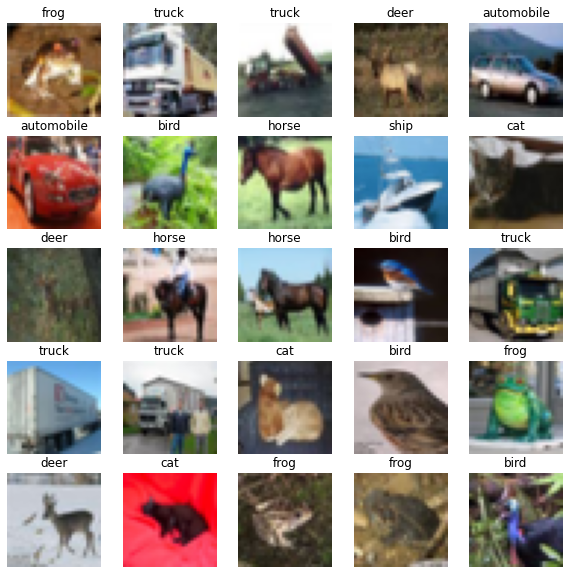

In [ ]:
image_batch, label_batch = x_train[:32], y_train[:32]
show_batch(image_batch, label_batch)

#### Test Set

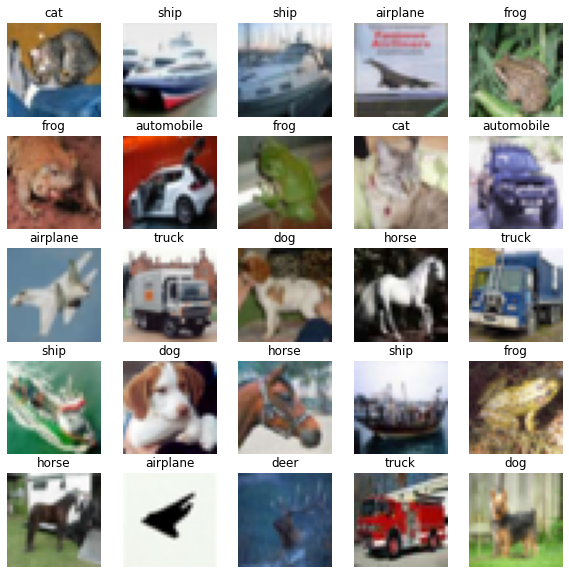

In [ ]:
image_batch, label_batch = x_test[:32], y_test[:32]
show_batch(image_batch, label_batch)

# Model

In [ ]:
from models.resnet import resnet_v1

In [ ]:
def Model():
  return resnet_v1((32,32,3), 20) ## Returns a ResNet20 model.

# Callbacks

In [ ]:
earlystoper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, verbose=0, mode='auto',
    restore_best_weights=True ## This will ensure the best instance of the model over the validation set.
)

# Train with Cutout Augmentation

#### Cutout Dataloader

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32

trainloader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
testloader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

def augment_cutout(image, label):
  img = tfa.image.random_cutout(image, (10,10), constant_values = 0)
  
  return img, label

def preprocess_image(image, label):
  img = tf.cast(image, tf.float32)
  img = img/255.

  return img, label

trainloader = (
    trainloader
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .map(augment_cutout, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

testloader = (
    testloader
    .map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

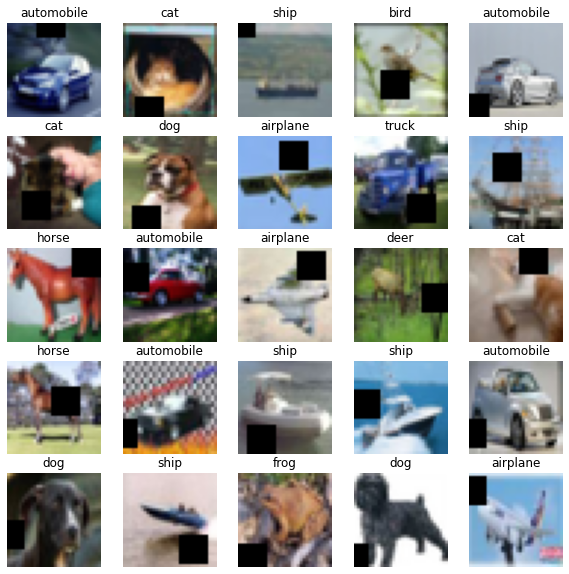

In [ ]:
image_batch, label_batch = next(iter(trainloader))
show_batch(image_batch, label_batch)

#### Initialize Model

In [ ]:
keras.backend.clear_session()
model = Model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

#### Compile

In [ ]:
model.compile('adam', 'sparse_categorical_crossentropy', metrics=['acc'])

#### Wandb Init

In [ ]:
wandb.init(entity='authors', project='tfaugmentation')

W&B Run: https://app.wandb.ai/authors/tfaugmentation/runs/1tzvl40d

#### Train

In [ ]:
EPOCHS = 100

_ = model.fit(trainloader,
          epochs=EPOCHS,
          validation_data=testloader,
          callbacks=[WandbCallback(),
                     earlystoper])

#### Save your hardwork

In [ ]:
%cd ../../

/


In [ ]:
model.save('gdrive/My Drive/DataAugmentation/cutout.h5')

## Evaluate

#### Evaluate on CIFAR-10

In [ ]:
loss, accuracy = model.evaluate(testloader, callbacks=[WandbCallback()])
print('Test Error Rate: ', round((1-accuracy)*100, 2))

313/313 [==============================] - 3s 10ms/step - loss: 0.8329 - acc: 0.8149
Test Error Rate:  18.51


# Ablation Study

> The aim of this study is to look at the dependence of cutout size to the test error rate. 

In [ ]:
def prepare_trainloader(cutsize):

  def augment_cutout(image, label):
    img = tfa.image.random_cutout(image, (cutsize, cutsize), constant_values = 0)
    
    return img, label

  trainloader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
  testloader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

  trainloader = (
      trainloader
      .shuffle(1024)
      .map(preprocess_image, num_parallel_calls=AUTO)
      .batch(BATCH_SIZE)
      .map(augment_cutout, num_parallel_calls=AUTO)
      .prefetch(AUTO)
  )

  testloader = (
      testloader
      .map(preprocess_image, num_parallel_calls=AUTO)
      .batch(BATCH_SIZE)
      .prefetch(AUTO)
  )

  return trainloader, testloader

In [ ]:
## As used by the autors of Cutout
CUT_SIZES = [4, 8, 12, 16, 20, 24]

In [ ]:
keras.backend.clear_session()
model = Model()

model.save('initial_wt.h5')

In [ ]:
for cutsize in CUT_SIZES:
  print('[INFO] Using cutsize: ', cutsize)
  ## Get cutout data loader with cutsize
  trainloader, testloader = prepare_trainloader(cutsize)
  ## Initalize model
  keras.backend.clear_session()
  model = Model()
  model.load_weights('initial_wt.h5')
  ## Compile model
  model.compile('adam', 'sparse_categorical_crossentropy', metrics=['acc'])
  ## Wandb init
  wandb.init(entity='authors', project='tfaugmentation')
  _ = model.fit(trainloader,
          epochs=100,
          validation_data=testloader,
          callbacks=[WandbCallback(),
                     earlystoper])
  ## save model
  model.save('model_cutout_{}.h5'.format(cutsize))

[INFO] Using cutsize:  4


Epoch 1/100
1563/1563 [==============================] - 72s 46ms/step - loss: 1.5663 - acc: 0.4914 - val_loss: 1.4837 - val_acc: 0.5345
Epoch 2/100
1563/1563 [==============================] - 71s 45ms/step - loss: 1.1481 - acc: 0.6485 - val_loss: 1.2733 - val_acc: 0.6219
Epoch 3/100
1563/1563 [==============================] - 71s 45ms/step - loss: 0.9697 - acc: 0.7180 - val_loss: 1.0505 - val_acc: 0.6925
Epoch 4/100
1563/1563 [==============================] - 70s 45ms/step - loss: 0.8654 - acc: 0.7552 - val_loss: 1.0619 - val_acc: 0.7104
Epoch 5/100
1563/1563 [==============================] - 71s 45ms/step - loss: 0.7967 - acc: 0.7821 - val_loss: 1.1260 - val_acc: 0.6864
Epoch 6/100
1563/1563 [==============================] - 71s 45ms/step - loss: 0.7411 - acc: 0.8027 - val_loss: 1.0326 - val_acc: 0.7238
Epoch 7/100
1563/1563 [==============================] - 70s 45ms/step - loss: 0.7001 - acc: 0.8198 - val_loss: 1.1330 - val_acc: 0.7055
Epoch 8/100
1563/1563 [==================

Epoch 1/100
1563/1563 [==============================] - 72s 46ms/step - loss: 1.6002 - acc: 0.4772 - val_loss: 1.7871 - val_acc: 0.4687
Epoch 2/100
1563/1563 [==============================] - 71s 45ms/step - loss: 1.2046 - acc: 0.6277 - val_loss: 1.1644 - val_acc: 0.6390
Epoch 3/100
1563/1563 [==============================] - 71s 46ms/step - loss: 1.0365 - acc: 0.6911 - val_loss: 1.1189 - val_acc: 0.6728
Epoch 4/100
1563/1563 [==============================] - 71s 45ms/step - loss: 0.9276 - acc: 0.7315 - val_loss: 0.9649 - val_acc: 0.7222
Epoch 5/100
1563/1563 [==============================] - 71s 45ms/step - loss: 0.8577 - acc: 0.7610 - val_loss: 1.2848 - val_acc: 0.6675
Epoch 6/100
1563/1563 [==============================] - 71s 45ms/step - loss: 0.8007 - acc: 0.7838 - val_loss: 0.9139 - val_acc: 0.7454
Epoch 7/100
1563/1563 [==============================] - 71s 45ms/step - loss: 0.7631 - acc: 0.7981 - val_loss: 0.8412 - val_acc: 0.7771
Epoch 8/100
1563/1563 [==================

Epoch 1/100
1563/1563 [==============================] - 72s 46ms/step - loss: 1.6334 - acc: 0.4648 - val_loss: 1.2729 - val_acc: 0.5995
Epoch 2/100
1563/1563 [==============================] - 71s 45ms/step - loss: 1.2376 - acc: 0.6143 - val_loss: 1.2262 - val_acc: 0.6203
Epoch 3/100
1563/1563 [==============================] - 71s 46ms/step - loss: 1.0761 - acc: 0.6757 - val_loss: 1.1670 - val_acc: 0.6606
Epoch 4/100
1563/1563 [==============================] - 71s 45ms/step - loss: 0.9761 - acc: 0.7159 - val_loss: 1.0764 - val_acc: 0.6945
Epoch 5/100
1563/1563 [==============================] - 71s 45ms/step - loss: 0.9096 - acc: 0.7369 - val_loss: 0.9828 - val_acc: 0.7252
Epoch 6/100
1563/1563 [==============================] - 71s 45ms/step - loss: 0.8576 - acc: 0.7612 - val_loss: 1.1308 - val_acc: 0.6875
Epoch 7/100
1563/1563 [==============================] - 70s 45ms/step - loss: 0.8170 - acc: 0.7763 - val_loss: 1.0431 - val_acc: 0.7244
Epoch 8/100
1563/1563 [==================

Epoch 1/100
1563/1563 [==============================] - 72s 46ms/step - loss: 1.7042 - acc: 0.4375 - val_loss: 2.7301 - val_acc: 0.3307
Epoch 2/100
1563/1563 [==============================] - 71s 46ms/step - loss: 1.3226 - acc: 0.5823 - val_loss: 1.3094 - val_acc: 0.5973
Epoch 3/100
1563/1563 [==============================] - 71s 46ms/step - loss: 1.1538 - acc: 0.6466 - val_loss: 1.0888 - val_acc: 0.6806
Epoch 4/100
1563/1563 [==============================] - 71s 45ms/step - loss: 1.0471 - acc: 0.6877 - val_loss: 1.1625 - val_acc: 0.6843
Epoch 5/100
1563/1563 [==============================] - 72s 46ms/step - loss: 0.9765 - acc: 0.7155 - val_loss: 1.0179 - val_acc: 0.7239
Epoch 6/100
1563/1563 [==============================] - 71s 46ms/step - loss: 0.9282 - acc: 0.7327 - val_loss: 1.0533 - val_acc: 0.7077
Epoch 7/100
1563/1563 [==============================] - 71s 46ms/step - loss: 0.8884 - acc: 0.7515 - val_loss: 0.9607 - val_acc: 0.7274
Epoch 8/100
1563/1563 [==================

In [ ]:
ablation_dict = {}

for file in os.listdir('/content/DataAugmentationTF'):
  if file.endswith('.h5') and 'initial' not in file:
    model.load_weights('/content/DataAugmentationTF/'+file)
    loss, acc = model.evaluate(testloader, verbose=0)
    print(file, (1-acc)*100)
    ablation_dict[int(file.split('.')[0].split('_')[-1])] = round((acc)*100, 2)

model_cutout_12.h5 19.510000944137573
model_cutout_20.h5 21.52000069618225
model_cutout_16.h5 19.529998302459717
model_cutout_4.h5 23.170000314712524
model_cutout_8.h5 22.289997339248657
model_cutout_24.h5 16.750001907348633


In [ ]:
ablation_dict

{4: 76.83, 8: 77.71, 12: 80.49, 16: 80.47, 20: 78.48, 24: 83.25}

In [ ]:
cutsize, test_acc = zip(*sorted(zip(list(ablation_dict.keys())[:-1], list(ablation_dict.values())[:-1])))

In [ ]:
wandb.init(entity='authors', project='tfaugmentation')

for k, v in zip(cutsize, test_acc):
  wandb.log({'cut size': k, 'test accuracy %': v})

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(cutsize, test_acc)
plt.title('Cut size vs test accuracy')
plt.xlabel('Cut Size')
plt.ylabel('Test Accuracy in %')
plt.grid(True)
# plt.show()

wandb.log({'cutsize vs test acc': plt})
plt.close()